In [1]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

from sklearn import preprocessing
from sklearn.covariance import OAS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline

import torch
from torch.optim import RMSprop, Adam, SGD
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from torch.optim.lr_scheduler import ReduceLROnPlateau

random_state = 42

---
## Preparation

In [2]:
base_dir = "2_NN_outputs/"
model_dir = base_dir + "models/"
runs_dir = base_dir + "runs/"

# shutil.rmtree(model_dir, ignore_errors=True)
# shutil.rmtree(runs_dir, ignore_errors=True)
# os.makedirs(model_dir, exist_ok=True)
# os.makedirs(runs_dir, exist_ok=True)

### Device


In [3]:
# PyTorch Device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device: {}".format(device))

Device: cuda


### Set seeds


In [4]:
# For reproducibility, fix all the seeds
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.
    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

### Data Layer


In [5]:
class MyDataset(Dataset):
    # Save X and y as Tensors, accordingly to the type of the data
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)

        self.num_features = X.shape[1]

    # Dataset size
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

### Neural Network Architectures

In [6]:
class NeuralNetworkSimple(nn.Module):
    def __init__(self, input_size, hidden_size, depth):
        super(NeuralNetworkSimple, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )

        self.hidden_layers = nn.Sequential(*[nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (depth - 1))

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+ReLU]*depth"

In [7]:
class NeuralNetworkDropout(nn.Module):
    def __init__(self, input_size, hidden_size, depth, dropout_rate):
        super(NeuralNetworkDropout, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

        self.hidden_layers = nn.Sequential(
            *[
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
            ]
            * (depth - 1)
        )

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+ReLU+Dropout(dropout_rate)]*depth"

In [8]:
class NeuralNetworkBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, depth):
        super(NeuralNetworkBatchNorm, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        )

        self.hidden_layers = nn.Sequential(
            *[
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
            ]
            * (depth - 1)
        )

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+BatchNorm1d+ReLU]*depth"

In [9]:
class NeuralNetworkDropoutBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, depth, dropout_rate):
        super(NeuralNetworkDropoutBatchNorm, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

        self.hidden_layers = nn.Sequential(
            *[
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
            ]
            * (depth - 1)
        )

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth"

### Early Stopper

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, delta=0):
        self.patience: int = patience
        self.delta: int = delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss <= (self.min_validation_loss - self.delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            # print("\tEarly stopper: {}/{} epochs".format(self.counter, self.patience))
            if self.counter >= self.patience:
                return True

### Train Function


In [11]:
# Function for the training process
def train_model(
    model: nn.Module,  # instance of class to train
    criterion,  # instance of loss function
    optimizer,  # instance of optimizer
    epochs,  # number of
    train_loader: DataLoader,
    val_loader: DataLoader,
    scheduler,
    early_stopper,
    device,  # to train on
    log_writer,
    log_name,
):
    n_iter = 0
    best_valid_loss = float("inf")  # initialized to worst possible value

    # EPOCHS
    for epoch in range(epochs):
        model.train()  # activate training mode (for BatchNorm or Dropout)

        # BATCHES
        for data, targets in train_loader:  # get_item from MyDataset class (single item or batch)
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()  # gradient to zero

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)  # reshape because MSELoss requires same dimensionality
            log_writer.add_scalar("Loss train/batches", loss, n_iter)  # plot the batches

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1

        # Valuation
        y_test, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred.squeeze(), y_test)
        log_writer.add_scalar("Loss val/epochs", loss_val, epoch)  # plot the epochs

        scheduler.step(loss_val)

        # Save the model with best loss through the epochs
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            torch.save(model.state_dict(), model_dir + log_name)

        # Early Stopping
        if early_stopper.early_stop(loss_val.item()):
            print("Early stopped!")
            break

### Test Function


In [12]:
def test_model(model: nn.Module, data_loader: DataLoader, device) -> tuple[Tensor, Tensor, Tensor]:
    model.eval()  # activate evaluation mode (for BatchNorm or Dropout)

    y_pred = []
    y_test = []

    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)

        y_pred.append(model(data))  # accumulate predictions
        y_test.append(targets)  # accumulate labels

    y_test = torch.stack(y_test).squeeze()
    y_pred = torch.stack(y_pred).squeeze()
    return y_test, y_pred

---

### Data Acquisition


In [13]:
df = pd.read_csv("train.csv").drop_duplicates()
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])

df_X = df.iloc[:, 1:].values
df_y = df.iloc[:, 0].values
indices = np.arange(df_X.shape[0])

# Separate indices in train/val/set (70 train, 20 val, 10 test)
train_idx, test_idx = train_test_split(indices, test_size=0.3, stratify=df_y, random_state=random_state)
val_idx, test_idx = train_test_split(test_idx, test_size=1 / 3, stratify=df_y[test_idx], random_state=random_state)

print("Train: ", len(train_idx))
print("Validation: ", len(val_idx))
print("Test: ", len(test_idx))

Rows:  252123
Columns:  91
Train:  176486
Validation:  50424
Test:  25213


### Preprocessing

In [14]:
# %%script false --no-raise-error

# pipeline = Pipeline([("raw", None)])
# preprocess_name = "RAW"

# pipeline = Pipeline(
#     steps=[
#         ("min-max", preprocessing.MinMaxScaler()),
#         ("l2", preprocessing.Normalizer(norm="l2")),
#     ]
# )
# preprocess_name = "MinMax+L2"

pipeline = Pipeline(
    steps=[
        ("std", preprocessing.StandardScaler()),
        ("l2", preprocessing.Normalizer(norm="l2")),
    ]
)
preprocess_name = "STD+L2"

# pipeline = Pipeline(
#     steps=[
#         ("std", preprocessing.StandardScaler()),
#         ("l2", preprocessing.Normalizer(norm="l2")),
#         ("lda", LinearDiscriminantAnalysis(solver="eigen", shrinkage=None, covariance_estimator=OAS())),
#     ]
# )
# preprocess_name = "Std+L2+LDA"

# pipeline = Pipeline(
#     [
#         ("min-max", preprocessing.MinMaxScaler()),
#         ("lda", LinearDiscriminantAnalysis(solver="eigen", covariance_estimator=OAS())),
#         ("nys", Nystroem(random_state=random_state, n_jobs=-1, gamma=0.010, n_components=1000)),
#     ]
# )
# preprocess_name = "MinMax+LDA+NYS"

pipeline.fit(df_X[train_idx], df_y[train_idx])

df_X_t = pipeline.transform(df_X)

### Hyperparameters


In [15]:
hidden_size = [256]  # 128, 256, 512, 1024]

batch_size = [48]  # [8, 16, 32, 64]

depth = [2]  # [3, 4, 5]

learning_rate = [0.0001]  # [0.001, 0.1]

num_epochs = [200]


# def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
#     def _log_cosh(x: torch.Tensor) -> torch.Tensor:
#         return x + torch.nn.functional.softplus(-2.0 * x) - math.log(2.0)

#     return torch.mean(_log_cosh(y_pred - y_true))


# class LogCoshLoss(torch.nn.Module):
#     def init(self):
#         super().init()

#     def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
#         return log_cosh_loss(y_pred, y_true)


class LogCoshLoss(torch.nn.Module):
    def init(self):
        super().init()

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return torch.mean(y_pred - y_true + torch.nn.functional.softplus(-2.0 * (y_pred - y_true)) - math.log(2.0))


criterion = [nn.MSELoss()]  # nn.L1Loss(), nn.HuberLoss(), LogCoshLoss()

optimizer = [RMSprop]  # Adam, SGD
momentum = [0.9]  # 0.9

scheduler_patience = [21]
scheduler_threshold = [1]
scheduler_threshold_mode = ["abs"]  # "rel"
scheduler_factor = [0.1]
scheduler_min_lr = [0.0000001]

early_stopper_patience = [20]

dropout_rate = [0.1]

hyperparameters = list(
    product(
        hidden_size,
        depth,
        num_epochs,
        batch_size,
        learning_rate,
        criterion,
        optimizer,
        scheduler_patience,
        scheduler_threshold,
        momentum,
        dropout_rate,
        early_stopper_patience,
        scheduler_threshold_mode,
        scheduler_factor,
        scheduler_min_lr,
    )
)
n_comb = len(hyperparameters)
print(f"Combinations size: {n_comb}")

Combinations size: 1


### Run

In [315]:
best_loss = np.inf
best_combination = None
best_model = None

results_tt = pd.DataFrame(
    columns=[
        "ID",
        "R^2",
        "MSE",
        "preprocess",
        "NN_architecture",
        "depth",
        "hidden_size",
        "dropout_rate",
        "batch_size",
        "learning_rate",
        "criterion",
        "optimizer",
        "momentum",
        "scheduler_patience",
        "scheduler_threshold",
        "scheduler_threshold_mode",
        "scheduler_factor",
        "scheduler_min_lr",
        "early_stopper_patience",
        "num_epochs",
    ]
)

for n_iter, (
    hidden_size,
    depth,
    num_epochs,
    batch_size,
    learning_rate,
    criterion,
    optimizer,
    scheduler_patience,
    scheduler_threshold,
    momentum,
    dropout_rate,
    early_stopper_patience,
    scheduler_threshold_mode,
    scheduler_factor,
    scheduler_min_lr,
) in enumerate(hyperparameters):
    fix_random(random_state)
    print("\n=================================================================================")
    print(f"Iteration {n_iter+1}/{n_comb}")

    # Data Loaders
    my_dataset = MyDataset(df_X_t, df_y)
    train_loader = DataLoader(Subset(my_dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(my_dataset, val_idx), batch_size=1)
    test_loader = DataLoader(Subset(my_dataset, test_idx), batch_size=1)

    model = NeuralNetworkDropoutBatchNorm(my_dataset.num_features, hidden_size, depth=depth, dropout_rate=dropout_rate)
    model.to(device)

    optimizer = optimizer(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = ReduceLROnPlateau(
        optimizer,
        patience=scheduler_patience,
        threshold=scheduler_threshold,
        threshold_mode=scheduler_threshold_mode,
        factor=scheduler_factor,
        min_lr=scheduler_min_lr,
        verbose=True,
    )

    early_stopper = EarlyStopper(patience=early_stopper_patience, delta=0.1)

    log_name = datetime.now().strftime("%Y%m%d-%H%M%S") + str(datetime.now().microsecond // 1000).zfill(3)
    log_writer = SummaryWriter(runs_dir + log_name)

    # Save configuration to df
    results_tt.loc[len(results_tt)] = [
        log_name,
        None,
        None,
        preprocess_name,
        model._get_description(),
        depth,
        hidden_size,
        dropout_rate,
        batch_size,
        learning_rate,
        criterion,
        optimizer.__class__.__name__,
        momentum,
        scheduler_patience,
        scheduler_threshold,
        scheduler_threshold_mode,
        scheduler_factor,
        scheduler_min_lr,
        early_stopper_patience,
        num_epochs,
    ]
    print(results_tt.loc[len(results_tt) - 1])

    # Train
    train_model(
        model,
        criterion,
        optimizer,
        num_epochs,
        train_loader,
        val_loader,
        scheduler,
        early_stopper,
        device,
        log_writer,
        log_name,
    )

    # Load best model (saven in the train function)
    model.load_state_dict(torch.load(model_dir + log_name))
    model.to(device)

    # Test
    y_true, y_pred = test_model(model, test_loader, device)
    test_loss = criterion(y_pred, y_true)
    print(f"\nTest loss (for given criterion): {test_loss:.4f}")
    r2 = r2_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    mse = mean_squared_error(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    print(f"R^2: {r2:.4f}, MSE:{mse:.4f}")

    # Add results to df
    results_tt.loc[len(results_tt) - 1, "R^2"] = r2
    results_tt.loc[len(results_tt) - 1, "MSE"] = mse
    results_tt.loc[[len(results_tt) - 1]].to_csv("2_output.csv", mode="a", index=False, header=False)

    if test_loss < best_loss:
        best_model = model
        best_combination = results_tt.loc[len(results_tt) - 1]

    log_writer.flush()
    log_writer.close()


Iteration 1/1
ID                                                         20240208-121353112
R^2                                                                      None
MSE                                                                      None
preprocess                                                         Std+L2+LDA
NN_architecture             [Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]...
depth                                                                       2
hidden_size                                                               256
dropout_rate                                                              0.1
batch_size                                                                 48
learning_rate                                                          0.0001
criterion                                                           MSELoss()
optimizer                                                             RMSprop
momentum                                         

Epoch 00063: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00098: reducing learning rate of group 0 to 1.0000e-06.
Early stopped!

Test loss (for given criterion): 72.1245
R^2: 0.3448, MSE:72.1245


### Best results

In [316]:
print("Best combination:")
print(best_combination)

Best combination:
ID                                                         20240208-121353112
R^2                                                                  0.344759
MSE                                                                 72.124512
preprocess                                                         Std+L2+LDA
NN_architecture             [Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]...
depth                                                                       2
hidden_size                                                               256
dropout_rate                                                              0.1
batch_size                                                                 48
learning_rate                                                          0.0001
criterion                                                           MSELoss()
optimizer                                                             RMSprop
momentum                                      

In [317]:
pd.read_csv("2_output.csv").sort_values(by="R^2", ascending=False).style.format(precision=7)

,ID,R^2,MSE,preprocess,NN_architecture,depth,hidden_size,dropout_rate,batch_size,learning_rate,criterion,optimizer,momentum,scheduler_patience,scheduler_threshold,scheduler_threshold_mode,scheduler_factor,scheduler_min_lr,early_stopper_patience,num_epochs
57,20240208-072156568,0.3555687,70.9346700,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000001,200,200
53,20240208-043844985,0.3555687,70.9346700,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000000,20,200
54,20240208-051928590,0.3555687,70.9346700,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000000,30,200
47,20240208-014736321,0.3530227,71.2149000,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000001,15,200
49,20240208-025527765,0.3526596,71.2548600,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,23,1,abs,0.1000000,0.0000001,15,200
48,20240208-022456512,0.3525551,71.2663650,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,22,1,abs,0.1000000,0.0000001,15,200
46,20240208-011702888,0.3522753,71.2971650,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,19,1,abs,0.1000000,0.0000001,15,200
45,20240208-004258554,0.3521859,71.3070100,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,20,1,abs,0.1000000,0.0000001,15,200
44,20240208-001306254,0.3513533,71.3986700,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,15,1,abs,0.1000000,0.0000001,15,200
38,20240207-204322677,0.3506504,71.4760360,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,200,1,abs,0.1000000,0.0000001,200,200


In [318]:
y_true, y_pred = test_model(best_model, test_loader, device)

mse = mean_squared_error(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
r2 = r2_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

print("MSE:", mse)
print("R2:", r2)

MSE: 72.12451
R2: 0.34475902316702767


In [319]:
# df = pd.read_csv("2_output.csv")

# df.insert(len(df.columns) - 2, "scheduler_min_lr", 0)

# df.to_csv("2_output.csv", index=False)

In [320]:
import plotly.graph_objects as go

df = pd.read_csv("2_output_old_proportions.csv").drop("ID", axis=1)

df["R^2"] = df["R^2"].round(2)
df["MSE"] = df["MSE"].round(2)

for col in df.columns:
    if col not in ["R^2", "MSE"]:
        df[col] = df[col].fillna("None")
        df[col] = df[col].astype("object")

dimensions = []

for col in df.select_dtypes(include="object"):
    if col not in ["R^2", "MSE"]:
        unique_dict = {i: num for num, i in enumerate(df[col].unique())}
        df[col] = df[col].map(unique_dict)
        dimensions.append(
            dict(label=str(col), values=df[col], tickvals=list(unique_dict.values()), ticktext=list(unique_dict.keys()))
        )

for col in ["R^2", "MSE"]:
    dimensions.append(dict(label=str(col), values=df[col]))

fig = go.Figure(
    data=go.Parcoords(
        line=dict(color=df["MSE"], colorscale="viridis", showscale=True), dimensions=dimensions, labelangle=-15
    )
)

fig.update_traces(
    dimensions=[
        {**d, **{"tickvals": np.round(np.linspace(min(d["values"]), max(d["values"]), len(np.unique(d["values"]))), 2)}}
        for d in fig.to_dict()["data"][0]["dimensions"]
    ]
)

# fig.update_layout(
#     paper_bgcolor="floralwhite",
# )

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Confusion Matrix

R^2: 0.3555685564572645, MSE:70.9346694946289


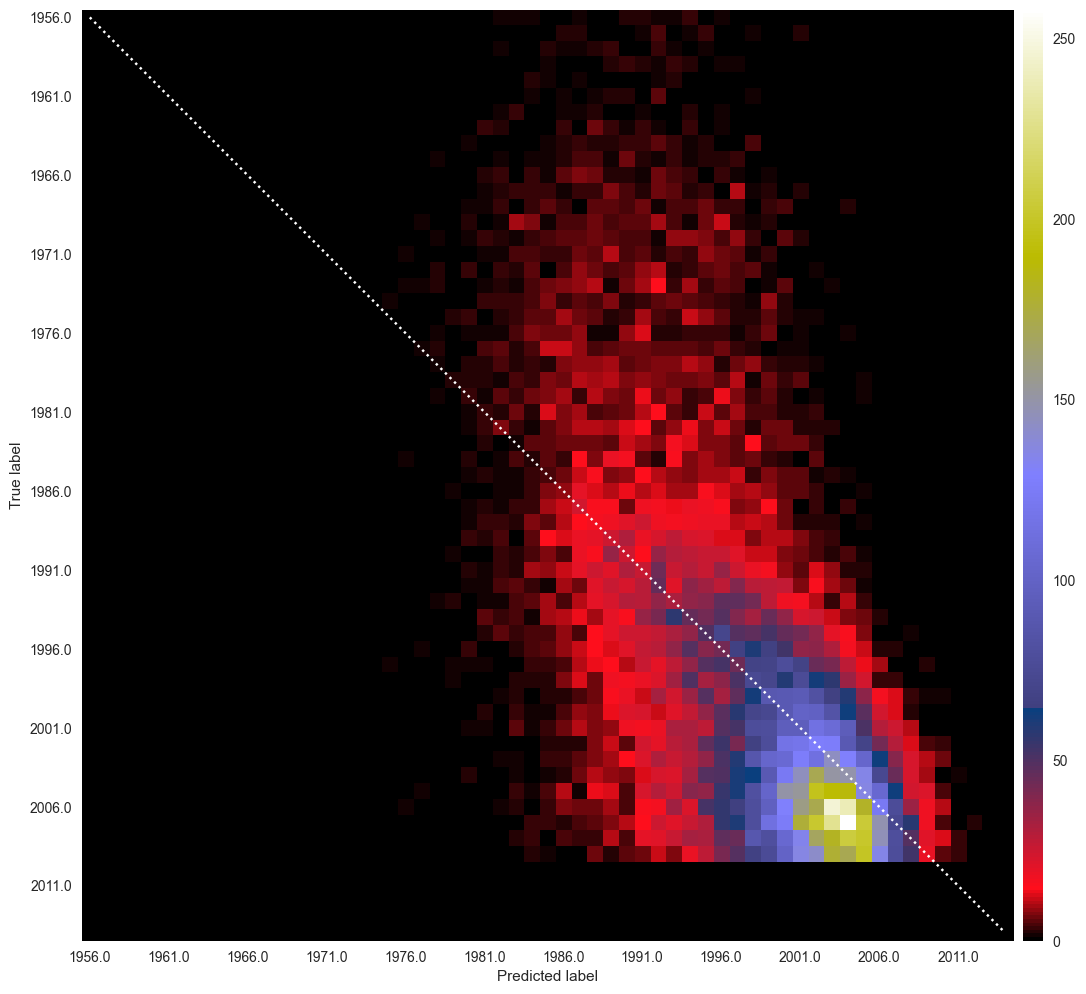

In [22]:
my_dataset = MyDataset(df_X_t, df_y)
test_loader = DataLoader(Subset(my_dataset, test_idx), batch_size=1)

model = NeuralNetworkDropoutBatchNorm(my_dataset.num_features, 256, depth=2, dropout_rate=0.1)
model.load_state_dict(torch.load(model_dir + "20240208-072156568"))
model.to(device)

y_true, y_pred = test_model(model, test_loader, device)
y_true = y_true.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f"R^2: {r2}, MSE:{mse}")

# Show confusion matrix of best result
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.style.use("seaborn-v0_8")


fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(None)
fig.tight_layout()
cmp = ConfusionMatrixDisplay.from_predictions(
    y_true,
    np.round(y_pred).astype(int),
    ax=ax,
    # xticks_rotation=80,
    include_values=False,
    cmap="gist_stern",  # "magma",
    colorbar=False,
)
ax.set_xticks(range(0, len(cmp.confusion_matrix), 5))
ax.set_yticks(range(0, len(cmp.confusion_matrix), 5))
ax.plot(range(len(cmp.confusion_matrix)), range(len(cmp.confusion_matrix)), color="white", linestyle="dotted")
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(cmp.im_, cax=cax)
plt.show()